In [14]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import network_utils as nuts

### Load in all of the .csv files containing the measurements of morphological domains

In [3]:
csv_file_path = '/Volumes/Tatum_SSD-1/Grad_School/m2py/Morphology_labels/OFET_morph_maps/Default_params/'
all_files = os.listdir(csv_file_path)
# print (all_files)
files = [fl for fl in all_files if fl[-1] == 'v']
print (len(files))
print (files)

37
['100C_10min_3_1_domain_metrics.csv', '100C_10min_3_3_domain_metrics.csv', '100C_10min_3_5-1_domain_metrics.csv', '100C_10min_3_5_domain_metrics.csv', '100C_10min_4_3_domain_metrics.csv', '100C_15min_6_4-1_domain_metrics.csv', '100C_15min_6_5_domain_metrics.csv', '100C_30min_8_1_domain_metrics.csv', '100C_30min_8_2_domain_metrics.csv', '100C_30min_8_5_domain_metrics.csv', '100C_5min_2_1_domain_metrics.csv', '100C_5min_2_2_domain_metrics.csv', '125C_10min_3_1_domain_metrics.csv', '125C_10min_4_2_domain_metrics.csv', '125C_10min_4_5_domain_metrics.csv', '125C_15min_5_3_domain_metrics.csv', '125C_15min_5_4_domain_metrics.csv', '125C_15min_6_5_domain_metrics.csv', '125C_30min_7_3_domain_metrics.csv', '125C_30min_8_1_domain_metrics.csv', '125C_5min_1_1_domain_metrics.csv', '125C_5min_1_4_domain_metrics.csv', '125C_5min_2_1_domain_metrics.csv', '125C_5min_2_2-1_domain_metrics.csv', '125C_5min_2_3_domain_metrics.csv', '150C_30min_7_1_domain_metrics.csv', '150C_30min_7_2_domain_metrics.csv'

In [4]:
df = pd.read_csv(csv_file_path+files[0])
df.head()

,Unnamed: 0,label,area,filled_area,extent,major_axis_length,minor_axis_length,eccentricity,orientation,perimeter
0,2,2.0,131.0,131.0,0.629808,17.341344,9.801985,0.824928,1.106268,47.213203
1,3,2.0,130.0,130.0,0.477941,17.126795,12.689212,0.671617,-1.136692,62.112698
2,4,2.0,118.0,118.0,0.546296,19.648663,9.649987,0.871088,-1.164292,54.142136
3,5,2.0,107.0,107.0,0.524510,16.195843,11.550745,0.700969,0.898264,51.556349
4,6,1.0,107.0,113.0,0.594444,14.939816,11.285126,0.655296,1.257751,54.935029


### For each time-temperature point:


- Sort domains by their phase
- Calculate average and standard deviation of domain descriptors
- Append those values to a phase-specific DataFrame

## Need to make sure domain also has time, temp, substrate, and device tags!!

In [5]:
# Define dataframes to hold statistics for each phase
final_df = pd.DataFrame(columns = ['Anneal_time', 'Anneal_temp', 'Substrate', 'Device',
                                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',
                                   
                                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev'])
#For each file, sort by GMM label, compute avg and stdev of each column, append values to phase summary dataframes
for fl in files:
    df = pd.read_csv(csv_file_path+fl)
    df.rename(columns = {'Unnamed: 0': 'Domain_label', 'label': 'GMM_label'}, inplace = True)
    
    # Obtain anneal time and temperature from filename
    if 'NOANNEAL' in fl:
        anl_time = 0
        anl_temp = 0
        
    else:
        temp_stop_indx = fl.index('C')
        anl_temp = int(fl[:temp_stop_indx])


        time_start_indx = temp_stop_indx+2
        time_stop_indx = fl.index('m')
        time_stop_indx = time_stop_indx
        anl_time = fl[time_start_indx:time_stop_indx]
        anl_time = int(anl_time)
        
    # Obtain substrate and device numnbers from filename
    sub = 0
    dev = 0
    
    sub_index = time_stop_indx + 4
    sub = fl[sub_index]
    
    dev_index = sub_index + 2
    dev = fl[dev_index]
    
    rel_areas = nuts.relative_areas(df)
    

    temp_p1 = df[df['GMM_label'] == 1]
    temp_p2 = df[df['GMM_label'] == 2]

    avg1 = temp_p1['area'].mean()
    std1 = temp_p1['area'].std()
    
    avg2 = temp_p1['filled_area'].mean()
    std2 = temp_p1['filled_area'].std()
    
    avg3 = temp_p1['extent'].mean()
    std3 = temp_p1['extent'].std()
    
    avg4 = temp_p1['major_axis_length'].mean()
    std4 = temp_p1['major_axis_length'].std()

    avg5 = temp_p1['minor_axis_length'].mean()
    std5 = temp_p1['minor_axis_length'].std()
    
    avg6 = temp_p1['eccentricity'].mean()
    std6 = temp_p1['eccentricity'].std()

    avg7 = temp_p1['orientation'].mean()
    std7 = temp_p1['orientation'].std()

    avg8 = temp_p1['perimeter'].mean()
    std8 = temp_p1['perimeter'].std()
    
    avg9 = temp_p2['area'].mean()
    std9 = temp_p2['area'].std()
    
    avg10 = temp_p2['filled_area'].mean()
    std10 = temp_p2['filled_area'].std()
    
    avg11 = temp_p2['extent'].mean()
    std11 = temp_p2['extent'].std()
    
    avg12 = temp_p2['major_axis_length'].mean()
    std12 = temp_p2['major_axis_length'].std()

    avg13 = temp_p2['minor_axis_length'].mean()
    std13 = temp_p2['minor_axis_length'].std()

    avg14 = temp_p2['eccentricity'].mean()
    std14 = temp_p2['eccentricity'].std()

    avg15 = temp_p2['orientation'].mean()
    std15 = temp_p2['orientation'].std()

    avg16 = temp_p2['perimeter'].mean()
    std16 = temp_p2['perimeter'].std()
    
    final_df = final_df.append(pd.Series({'Anneal_time':anl_time, 'Anneal_temp':anl_temp,
                                          'Substrate':sub, 'Device':dev,
                                          'p1_fraction':rel_areas[0],
                                          'p2_fraction':rel_areas[1], 'p1_area_avg':avg1,
                                          'p1_area_stdev':std1, 'p1_filled_area_avg':avg2,
                                          'p1_filled_area_stdev':std2, 'p1_extent_avg':avg3,
                                          'p1_extent_stdev':std3, 'p1_MajorAL_avg':avg4,
                                          'p1_MajorAL_stdev':std4, 'p1_MinorAL_avg':avg5,
                                          'p1_MinorAL_stdev':std5, 'p1_Ecc_avg':avg6,
                                          'p1_Ecc_stdev':std6,'p1_Orient_avg':avg7,
                                          'p1_Orient_stdev':std7, 'p1_Perim_avg':avg8,
                                          'p1_Perim_stdev':std8, 'p2_area_avg':avg9,
                                          'p2_area_stdev':std9, 'p2_filled_area_avg':avg10,
                                          'p2_filled_area_stdev':std10, 'p2_extent_avg':avg11,
                                          'p2_extent_stdev':std11, 'p2_MajorAL_avg':avg12,
                                          'p2_MajorAL_stdev':std12, 'p2_MinorAL_avg':avg13,
                                          'p2_MinorAL_stdev':std13, 'p2_Ecc_avg':avg14,
                                          'p2_Ecc_stdev':std14, 'p2_Orient_avg':avg15,
                                          'p2_Orient_stdev':std15, 'p2_Perim_avg':avg16,
                                          'p2_Perim_stdev':std16}), ignore_index = True)

In [6]:
final_df.head()

,Anneal_time,Anneal_temp,Substrate,Device,p1_area_avg,p1_area_stdev,p1_filled_area_avg,p1_filled_area_stdev,p1_extent_avg,p1_extent_stdev,...,p2_MinorAL_avg,p2_MinorAL_stdev,p2_Ecc_avg,p2_Ecc_stdev,p2_Orient_avg,p2_Orient_stdev,p2_Perim_avg,p2_Perim_stdev,p1_fraction,p2_fraction
0,10,100,3,1,15.060429,13.825293,15.094867,13.930399,0.760417,0.192680,...,4.485281,2.126590,0.752109,0.196612,0.273477,1.129281,18.169495,10.105495,0.496546,0.503454
1,10,100,3,3,24.529301,21.770880,24.550095,21.813084,0.711369,0.191432,...,5.656564,2.620309,0.759700,0.168874,0.153039,1.105821,24.341023,13.173599,0.470745,0.529255
2,10,100,3,5,31.114610,28.907570,31.171285,29.100225,0.725212,0.191643,...,5.713155,3.087032,0.765579,0.170177,0.115643,1.031045,24.335218,14.999830,0.503413,0.496587
3,10,100,3,5,16.867677,12.876565,16.895245,12.918527,0.753319,0.161260,...,3.886650,1.776345,0.743010,0.205036,0.101798,0.957505,14.855980,8.463103,0.501345,0.498655
4,10,100,4,3,23.082537,18.354319,23.096438,18.379911,0.720716,0.173655,...,3.845567,1.931087,0.758975,0.209781,0.055038,1.075792,15.034620,9.558353,0.439411,0.560589


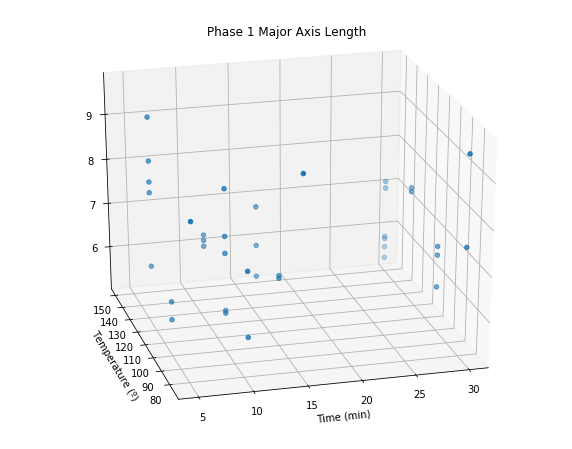

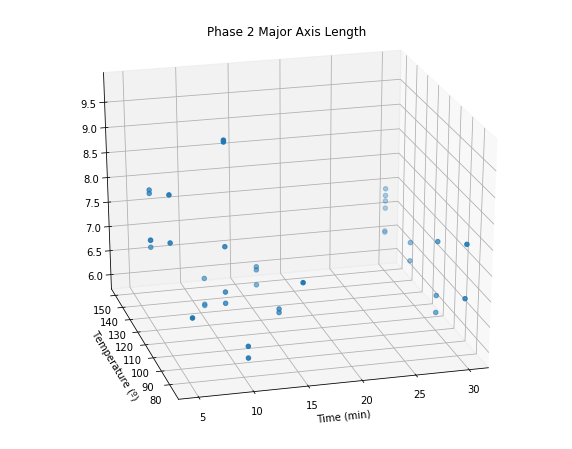

In [7]:
x1 = final_df['Anneal_time']
y1 = final_df['Anneal_temp']
z1 = final_df['p1_MajorAL_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 1 Major Axis Length')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 255)
plt.show()

x2 = final_df['Anneal_time']
y2 = final_df['Anneal_temp']
z2 = final_df['p2_MajorAL_avg']
fig2 = plt.figure(figsize = (10,8))
ax2 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('Phase 2 Major Axis Length')
ax2.scatter3D(x2,y2,z2)
ax2.view_init(25, 255)
plt.show()

# Now we need to read in the device data and associate it with its morphology descriptors

# This cell was for initially converting everything to pandas. A new, formatted & filtered spreadsheet now exists

In [7]:
# device_df = pd.DataFrame(columns = ['Sample', 'Temperature', 'Time', 'Substrate', 'Device', 'mu_lin_avg', 'mu_lin_SD',
#                                     'r_lin_avg', 'r_lin_sd', 'on_off_avg', 'on_off_sd', 'Vt_avg', 'Vt_sd'])


# c75 = pd.read_excel('/Users/wesleytatum/Desktop/OFET Linear Regime Analysis.xlsx', sheet_name = '75C Data Sorting',
#                     use_cols = ['Sample', 'Temperature', 'Time', 'mu_lin_avg', 'mu_lin_SD', 'r_lin_avg', 'r_lin_sd', 'on_off_avg',
#                                 'on_off_sd', 'Vt_avg', 'Vt_sd'])
# c75['Sample'] = c75['Sample'].fillna(method = 'ffill')

# for i in range(0,22):
#     sample = c75['Sample'][i*5]
#     temp = c75['Temperature'][i*5]
#     time = c75['Time'][i*5]
#     mu_av = c75['mu_lin_avg'][i*5+3]
#     mu_st = c75['mu_lin_SD'][i*5+4]
#     r_av = c75['r_lin_avg'][i*5+3]
#     r_st = c75['r_lin_sd'][i*5+4]
#     on_off_av = c75['on_off_avg'][i*5+3]
#     on_off_st = c75['on_off_sd'][i*5+4]
#     vt_av = c75['Vt_avg'][i*5+3]
#     vt_st = c75['Vt_sd'][i*5+4]
    
#     sub_start = sample.find('n') + 2
#     sub = sample[sub_start]
    
#     dev_start = sample.find('g') + 2
#     dev = sample[dev_start]
    
#     entry = pd.Series({'Sample':sample, 'Temperature':temp, 'Time':time, 'Substrate':sub, 'Device':dev, 'mu_lin_avg':mu_av,
#                        'mu_lin_SD':mu_st, 'r_lin_avg':r_av, 'r_lin_sd':r_st, 'on_off_avg':on_off_av, 'on_off_sd':on_off_st,
#                        'Vt_avg':vt_av, 'Vt_sd':vt_st})
    
#     device_df = device_df.append(entry, ignore_index = True)


# c100 = pd.read_excel('/Users/wesleytatum/Desktop/OFET Linear Regime Analysis.xlsx', sheet_name = '100C Data Sorting',
#                     use_cols = ['Sample', 'Temperature', 'Time', 'mu_lin_avg', 'mu_lin_SD', 'r_lin_avg', 'r_lin_sd', 'on_off_avg',
#                                 'on_off_sd', 'Vt_avg', 'Vt_sd'])
# c100['Sample'] = c100['Sample'].fillna(method = 'ffill')

# for i in range(0,22):
#     sample = c100['Sample'][i*5]
#     temp = c100['Temperature'][i*5]
#     time = c100['Time'][i*5]
#     mu_av = c100['mu_lin_avg'][i*5+3]
#     mu_st = c100['mu_lin_SD'][i*5+4]
#     r_av = c100['r_lin_avg'][i*5+3]
#     r_st = c100['r_lin_sd'][i*5+4]
#     on_off_av = c100['on_off_avg'][i*5+3]
#     on_off_st = c100['on_off_sd'][i*5+4]
#     vt_av = c100['Vt_avg'][i*5+3]
#     vt_st = c100['Vt_sd'][i*5+4]
    
#     sub_start = sample.find('n') + 2
#     sub = sample[sub_start]
    
#     dev_start = sample.find('g') + 2
#     dev = sample[dev_start]
    
#     entry = pd.Series({'Sample':sample, 'Temperature':temp, 'Time':time, 'Substrate':sub, 'Device':dev, 'mu_lin_avg':mu_av,
#                        'mu_lin_SD':mu_st, 'r_lin_avg':r_av, 'r_lin_sd':r_st, 'on_off_avg':on_off_av, 'on_off_sd':on_off_st,
#                        'Vt_avg':vt_av, 'Vt_sd':vt_st})
    
#     device_df = device_df.append(entry, ignore_index = True)


# c125 = pd.read_excel('/Users/wesleytatum/Desktop/OFET Linear Regime Analysis.xlsx', sheet_name = '125C Data Sorting',
#                     use_cols = ['Sample', 'Temperature', 'Time', 'mu_lin_avg', 'mu_lin_SD', 'r_lin_avg', 'r_lin_sd', 'on_off_avg',
#                                 'on_off_sd', 'Vt_avg', 'Vt_sd'])
# c125['Sample'] = c125['Sample'].fillna(method = 'ffill')

# for i in range(0,22):
#     sample = c125['Sample'][i*5]
#     temp = c125['Temperature'][i*5]
#     time = c125['Time'][i*5]
#     mu_av = c125['mu_lin_avg'][i*5+3]
#     mu_st = c125['mu_lin_SD'][i*5+4]
#     r_av = c125['r_lin_avg'][i*5+3]
#     r_st = c125['r_lin_sd'][i*5+4]
#     on_off_av = c125['on_off_avg'][i*5+3]
#     on_off_st = c125['on_off_sd'][i*5+4]
#     vt_av = c125['Vt_avg'][i*5+3]
#     vt_st = c125['Vt_sd'][i*5+4]
    
#     sub_start = sample.find('n') + 2
#     sub = sample[sub_start]
    
#     dev_start = sample.find('g') + 2
#     dev = sample[dev_start]
    
#     entry = pd.Series({'Sample':sample, 'Temperature':temp, 'Time':time, 'Substrate':sub, 'Device':dev, 'mu_lin_avg':mu_av,
#                        'mu_lin_SD':mu_st, 'r_lin_avg':r_av, 'r_lin_sd':r_st, 'on_off_avg':on_off_av, 'on_off_sd':on_off_st,
#                        'Vt_avg':vt_av, 'Vt_sd':vt_st})
    
#     device_df = device_df.append(entry, ignore_index = True)


# c150 = pd.read_excel('/Users/wesleytatum/Desktop/OFET Linear Regime Analysis.xlsx', sheet_name = '150C Data Sorting',
#                     use_cols = ['Sample', 'Temperature', 'Time', 'mu_lin_avg', 'mu_lin_SD', 'r_lin_avg', 'r_lin_sd', 'on_off_avg',
#                                 'on_off_sd', 'Vt_avg', 'Vt_sd'])
# c150['Sample'] = c150['Sample'].fillna(method = 'ffill')

# for i in range(0,22):
#     sample = c150['Sample'][i*5]
#     temp = c150['Temperature'][i*5]
#     time = c150['Time'][i*5]
#     mu_av = c150['mu_lin_avg'][i*5+3]
#     mu_st = c150['mu_lin_SD'][i*5+4]
#     r_av = c150['r_lin_avg'][i*5+3]
#     r_st = c150['r_lin_sd'][i*5+4]
#     on_off_av = c150['on_off_avg'][i*5+3]
#     on_off_st = c150['on_off_sd'][i*5+4]
#     vt_av = c150['Vt_avg'][i*5+3]
#     vt_st = c150['Vt_sd'][i*5+4]
    
#     sub_start = sample.find('n') + 2
#     sub = sample[sub_start]
    
#     dev_start = sample.find('g') + 2
#     dev = sample[dev_start]
    
#     entry = pd.Series({'Sample':sample, 'Temperature':temp, 'Time':time, 'Substrate':sub, 'Device':dev, 'mu_lin_avg':mu_av,
#                        'mu_lin_SD':mu_st, 'r_lin_avg':r_av, 'r_lin_sd':r_st, 'on_off_avg':on_off_av, 'on_off_sd':on_off_st,
#                        'Vt_avg':vt_av, 'Vt_sd':vt_st})
    
#     device_df = device_df.append(entry, ignore_index = True)

# This cell utilizes the formatted & filtered spreadsheet

In [15]:
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OFET_device_df.xlsx')
print(device_df.shape)
device_df.head()

(80, 15)


,Unnamed: 0,Unnamed: 0.1,Sample,Temperature,Time,Substrate,Device,mu_lin_avg,mu_lin_SD,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
0,0,0,75C-5min_1-IdVg-2-Vd-20,75,5,1,2,0.002176,0.000014,0.580171,0.013437,1119.582374,30.715757,-31.511376,0.198134
1,1,1,75C-5min_1-IdVg-4-Vd-20,75,5,1,4,0.004906,0.000259,0.551756,0.020972,892.258038,4.484375,-28.971871,0.461514
2,2,2,75C-5min_2-IdVg-1-Vd-20,75,5,2,1,0.004643,0.000015,0.557327,0.002400,20.595284,0.172757,-18.556867,0.166910
3,3,3,75C-5min_2-IdVg-3-Vd-20,75,5,2,3,0.012977,0.002372,0.581325,0.004444,619.347250,1024.656122,-21.054614,1.348128
4,4,4,75C-5min_2-IdVg-4-Vd-20,75,5,2,4,0.010087,0.000050,0.585769,0.006963,1812.113114,15.685197,-19.170370,0.165707


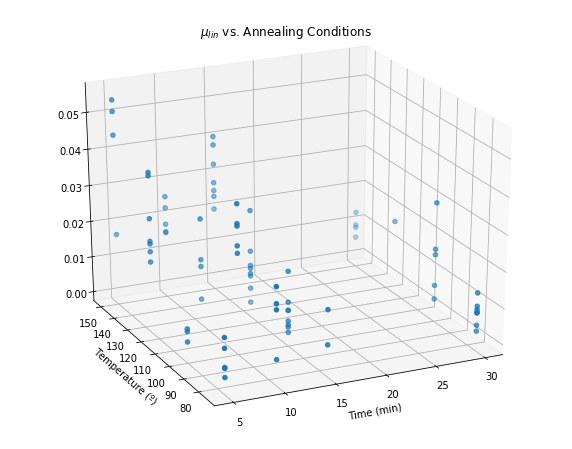

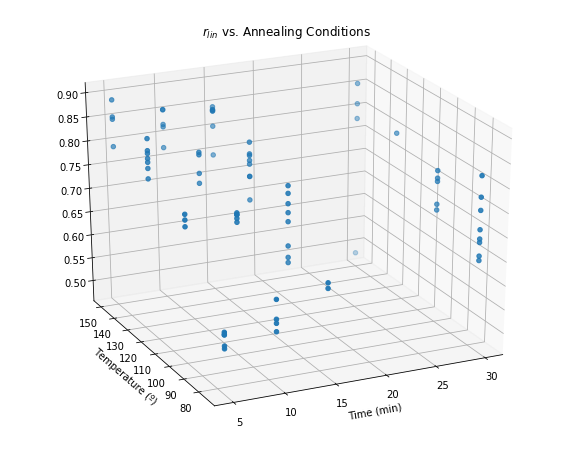

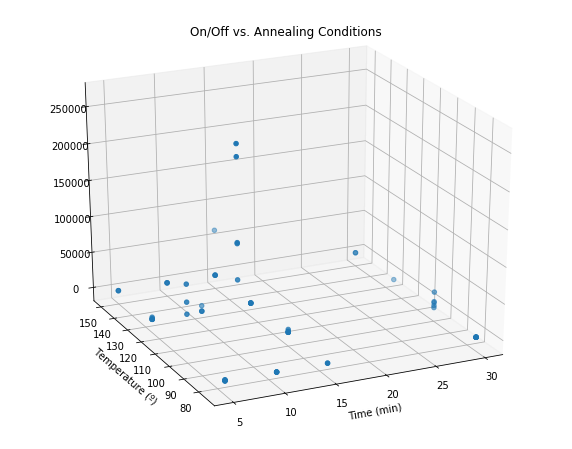

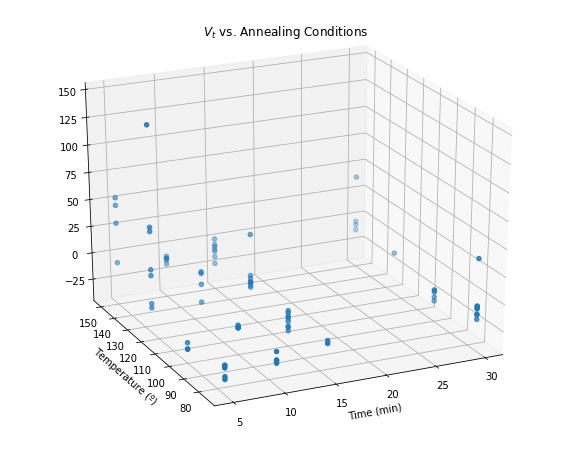

In [9]:
x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['mu_lin_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('$\mu_{lin}$ vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['r_lin_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('$r_{lin}$ vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['on_off_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('On/Off vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
# ax1.set_zscale('log')
plt.show()

x1 = device_df['Time']
y1 = device_df['Temperature']
z1 = device_df['Vt_avg']
fig1 = plt.figure(figsize = (10,8))
ax1 = plt.axes(projection = '3d')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (º)')
plt.title('$V_{t}$ vs. Annealing Conditions')
ax1.scatter3D(x1,y1,z1)
ax1.view_init(25, 245)
plt.show()

In [25]:
# device_df.to_excel('/Users/wesleytatum/Desktop/OFET_device_df.xlsx')

# Now that the data is read in plottable, we need to use all of these parameters to predict device performance


- Create a new df with only columns needed for models
- Make sure device data is properly matched with morphology data (via time, temp, substrate, device)
- Want to fit a function that predicts PCE, Jsc, Voc, and FF from morphology and processing conditions

$$
PCE, Jsc, Voc, FF = f(anneal time, anneal temp, major axis, minor axis, perimenter, orientation, eccentricity)
$$

The problem is that there are way more devices tested than AFM images taken and processed. So, for now, the dataframe will only contain device data for those devices with morphology data too. In the full model (_i.e._ the neural network model), I'll have to find a way to use all data in training.

In [13]:
# for each row in total_df, find row in device_df with same time, temp, sub, and dev. then append device values to total_df

final_df['mu_lin_avg'] = 0
final_df['r_lin_avg'] = 0
final_df['on_off_avg'] = 0
final_df['Vt_avg'] = 0

NA_count = 0 # NA = no anneal, whose filenames have different schemes

for i in range(len(final_df['Anneal_time'])):
    print (i)
    mu = 0
    r = 0
    oor = 0
    vt = 0
    
    time = final_df['Anneal_time'].iloc[i]
    temp = final_df['Anneal_temp'].iloc[i]
    sub = final_df['Substrate'].iloc[i]
    sub = int(sub)
    dev = final_df['Device'].iloc[i]
    dev = int(dev)
    
    time_df = device_df[device_df['Time'] == time]
    temp_df = time_df[time_df['Temperature'] == temp]
    sub_df = temp_df[temp_df['Substrate'] == sub]
    dev_row = sub_df[sub_df['Device'] == dev]
    
    
    if dev_row.shape[0] != 0:
    
        mu = dev_row['mu_lin_avg'].iloc[-1]
        r = dev_row['r_lin_avg'].iloc[-1]
        oor = dev_row['on_off_avg'].iloc[-1]
        vt = dev_row['Vt_avg'].iloc[-1]
        
    elif dev_row.shape[0] == 0:
        if time == 0:
            
            NA_df = device_df[device_df['Time'] == time]
            
            mu = NA_df['mu_lin_avg'].iloc[NA_count]
            r = NA_df['r_lin_avg'].iloc[NA_count]
            oor = NA_df['on_off_avg'].iloc[NA_count]
            vt = NA_df['Vt_avg'].iloc[NA_count]
            
            NA_count += 1 
            
        else:
            pass
    else:
        pass
        
    final_df['mu_lin_avg'].iloc[i] = mu
    final_df['r_lin_avg'].iloc[i] = r
    final_df['on_off_avg'].iloc[i] = oor
    final_df['Vt_avg'].iloc[i] = vt
    
final_df.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Anneal_time,Anneal_temp,Substrate,Device,p1_area_avg,p1_area_stdev,p1_filled_area_avg,p1_filled_area_stdev,p1_extent_avg,p1_extent_stdev,...,p2_Orient_avg,p2_Orient_stdev,p2_Perim_avg,p2_Perim_stdev,p1_fraction,p2_fraction,mu_lin_avg,r_lin_avg,on_off_avg,Vt_avg
0,10,100,3,1,15.060429,13.825293,15.094867,13.930399,0.760417,0.192680,...,0.273477,1.129281,18.169495,10.105495,0.496546,0.503454,0.027205,0.751935,83456.5773,-18.385927
1,10,100,3,3,24.529301,21.770880,24.550095,21.813084,0.711369,0.191432,...,0.153039,1.105821,24.341023,13.173599,0.470745,0.529255,0.038410,0.748463,133461.6840,-19.986533
2,10,100,3,5,31.114610,28.907570,31.171285,29.100225,0.725212,0.191643,...,0.115643,1.031045,24.335218,14.999830,0.503413,0.496587,0.025188,0.747956,132094.0970,-20.648421
3,10,100,3,5,16.867677,12.876565,16.895245,12.918527,0.753319,0.161260,...,0.101798,0.957505,14.855980,8.463103,0.501345,0.498655,0.025188,0.747956,132094.0970,-20.648421
4,10,100,4,3,23.082537,18.354319,23.096438,18.379911,0.720716,0.173655,...,0.055038,1.075792,15.034620,9.558353,0.439411,0.560589,0.032493,0.732737,245995.6098,-21.035315


In [11]:
final_df.to_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OFET_total_df.xlsx')

# Need to figure out how to sync morphology with device data, if there is no mutual substrate and device combos

In [20]:
# for each row in total_df, find row in device_df with same time, temp, sub, and dev. then append PCE, Jsc, Voc, and FF values to total_df

NA_count = 0 # NA = no anneal, whose filenames have different schemes

for i in range(len(total_df['Anneal_time'])):
    print (i)
    mu_av = 0
    mu_st = 0
    r_av = 0
    r_st = 0
    on_off_av = 0
    on_off_st = 0
    Vt_av = 0
    Vt_st = 0
    time = 0
    temp = 0
    sub = 0
    dev = 0
    
    time = total_df['Anneal_time'].iloc[i]
    temp = total_df['Anneal_temp'].iloc[i]
    sub = total_df['Substrate'].iloc[i]
    sub = int(sub)
    dev = total_df['Device'].iloc[i]
    dev = int(dev)
    
    time_df = device_df[device_df['Time'] == time]
    print (time_df.shape)
    temp_df = time_df[time_df['Temperature'] == temp]
    print (temp_df.shape)
    sub_df = temp_df[temp_df['Substrate'] == sub]
    print (sub_df.shape)
    dev_row = sub_df[sub_df['Device'] == dev]
    print (dev_row.shape)
    
    if dev_row.shape[0] != 0:
        
        mu_av = dev_row['mu_lin_avg'].iloc[-1]
        mu_st = dev_row['mu_lin_SD'].iloc[-1]
        r_av = dev_row['r_lin_avg'].iloc[-1]
        r_st = dev_row['r_lin_sd'].iloc[-1]
        on_off_av = dev_row['on_off_avg'].iloc[-1]
        on_off_st = dev_row['on_off_sd'].iloc[-1]
        Vt_av = dev_row['Vt_avg'].iloc[-1]
        Vt_st = dev_row['Vt_sd'].iloc[-1]
        
    elif dev_row.shape[0] == 0:
        if time == 0:
            
            NA_df = device_df[device_df['Time (min)'] == time]
            
            mu_av = NA_df['mu_lin_avg'].iloc[NA_count]
            mu_st = NA_df['mu_lin_SD'].iloc[NA_count]
            r_av = NA_df['r_lin_avg'].iloc[NA_count]
            r_st = NA_df['r_lin_sd'].iloc[NA_count]
            on_off_av = NA_df['on_off_avg'].iloc[NA_count]
            on_off_st = NA_df['on_off_sd'].iloc[NA_count]
            Vt_av = NA_df['Vt_avg'].iloc[NA_count]
            Vt_st = NA_df['Vt_sd'].iloc[NA_count]
            
            NA_count += 1 
            
        else:
            pass
    else:
        pass
    
    total_df['mu_lin_avg'].iloc[i] = mu_av
    total_df['mu_lin_sd'].iloc[i] = mu_st
    total_df['r_lin_avg'].iloc[i] = r_av
    total_df['r_lin_sd'].iloc[i] = r_st
    total_df['on_off_avg'].iloc[i] = on_off_av
    total_df['on_off_sd'].iloc[i] = on_off_st
    total_df['Vt_avg'].iloc[i] = Vt_av
    total_df['Vt_sd'].iloc[i] = Vt_st
    
print (total_df.shape)
total_df.head()

0
(18, 14)
(5, 14)
(3, 14)
(1, 14)
1
(18, 14)
(5, 14)
(3, 14)
(1, 14)
2
(18, 14)
(5, 14)
(3, 14)
(1, 14)
3
(18, 14)
(5, 14)
(3, 14)
(1, 14)
4
(18, 14)
(5, 14)
(2, 14)
(1, 14)
5
(25, 14)
(8, 14)
(5, 14)
(1, 14)
6
(25, 14)
(8, 14)
(5, 14)
(1, 14)
7
(18, 14)
(5, 14)
(3, 14)
(1, 14)
8
(18, 14)
(5, 14)
(3, 14)
(0, 14)
9
(18, 14)
(5, 14)
(3, 14)
(1, 14)
10
(19, 14)
(3, 14)
(0, 14)
(0, 14)
11
(19, 14)
(3, 14)
(0, 14)
(0, 14)
12
(18, 14)
(4, 14)
(2, 14)
(1, 14)
13
(18, 14)
(4, 14)
(2, 14)
(1, 14)
14
(18, 14)
(4, 14)
(2, 14)
(0, 14)
15
(25, 14)
(8, 14)
(3, 14)
(0, 14)
16
(25, 14)
(8, 14)
(3, 14)
(1, 14)
17
(25, 14)
(8, 14)
(5, 14)
(1, 14)
18
(18, 14)
(1, 14)
(1, 14)
(1, 14)
19
(18, 14)
(1, 14)
(0, 14)
(0, 14)
20
(19, 14)
(7, 14)
(3, 14)
(1, 14)
21
(19, 14)
(7, 14)
(3, 14)
(1, 14)
22
(19, 14)
(7, 14)
(4, 14)
(1, 14)
23
(19, 14)
(7, 14)
(4, 14)
(1, 14)
24
(19, 14)
(7, 14)
(4, 14)
(1, 14)
25
(18, 14)
(4, 14)
(3, 14)
(1, 14)
26
(18, 14)
(4, 14)
(3, 14)
(1, 14)
27
(18, 14)
(4, 14)
(3, 14)
(1, 14)
28

,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,...,Perim_stdev,GMM_label,mu_lin_avg,mu_lin_sd,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
0,10,100,3,1,5.856501,3.244681,3.075720,1.985903,0.760772,0.244835,...,8.561025,1,0.027205,0.000495,0.751935,0.002915,83456.5773,1672.053023,-18.385927,0.266716
1,10,100,3,3,7.550006,3.905505,4.143006,2.309477,0.773807,0.196397,...,11.215483,1,0.038410,0.000741,0.748463,0.001580,133461.6840,2586.760156,-19.986533,0.160197
2,10,100,3,5,8.577824,5.768438,4.665343,3.193484,0.773831,0.199696,...,13.063983,1,0.025188,0.000154,0.747956,0.008564,132094.0970,4613.253520,-20.648421,0.404781
3,10,100,3,5,5.914614,2.647315,3.398168,1.667982,0.745994,0.224604,...,7.433700,1,0.025188,0.000154,0.747956,0.008564,132094.0970,4613.253520,-20.648421,0.404781
4,10,100,4,3,7.179457,3.464021,3.944406,2.070579,0.771835,0.200995,...,9.691014,1,0.032493,0.000350,0.732737,0.001381,245995.6098,7239.904390,-21.035315,0.023485


# We have all our device and morphology data in total_df. Now we can use it to train regression models for in-depth plotting!!

In [12]:
X = total_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MinorAL_avg', 'Ecc_avg', 'Orient_avg', 'Perim_avg']] # all of the different features, including annealing conditions
Y = total_df[['mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']] # device performance

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

alphas = np.logspace(-6, 1, 200)
coeffs = {}
train_errors = []
test_errors = []

# for i, a in enumerate(alphas):
#     lasso = linear_model.Lasso(alpha = a)
#     lasso.fit(x_train, y_train)

#     y_train_pred = lasso.predict(x_train)
#     y_test_pred = lasso.predict(x_test)


#     train_mse = mean_squared_error(y_train, y_train_pred)
#     test_mse = mean_squared_error(y_test, y_test_pred)
    
#     coeffs[i]=lasso.coef_
#     train_errors.append(train_mse)
#     test_errors.append(test_mse)

# depths = np.arange(1, 9, 1)
# coeffs = {}
# train_errors = []
# test_errors = []

for i, d in enumerate(depths):
    tree = DecisionTreeRegressor(max_depth = d)
    tree.fit(x_train, y_train)
#     print (tree.n_features_)
#     print (tree.n_outputs_)

    y_train_pred = tree.predict(x_train)
    y_test_pred = tree.predict(x_test)


    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
print (train_errors)
print (test_errors)

NameError: name 'total_df' is not defined

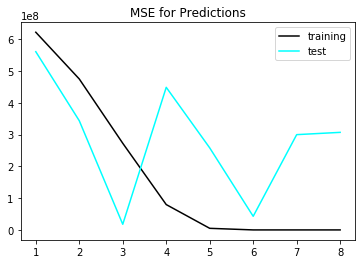

In [23]:
fig = plt.Figure(figsize = (30,20))
plt.plot(depths, train_errors, c = 'k', label = 'training')
plt.plot(depths, test_errors, c = 'cyan', label = 'test')
plt.legend()
# ax = plt.gca()
# ax.set_xscale('log')
plt.title('MSE for Predictions')
plt.show()

In [24]:
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(x_train, y_train)
#     print (tree.n_features_)
#     print (tree.n_outputs_)

y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

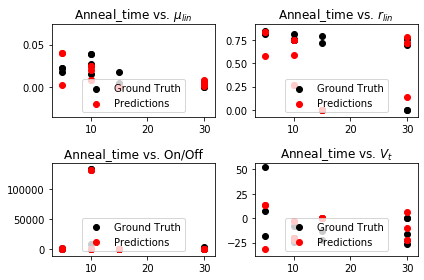

In [25]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['Anneal_time'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_time'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['Anneal_time'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_time'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['Anneal_time'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_time'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['Anneal_time'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_time'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_time vs. $V_{t}$')

plt.tight_layout()
plt.show()

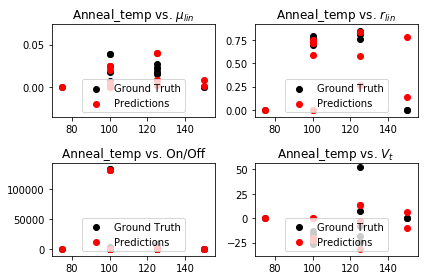

In [26]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['Anneal_temp'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_temp'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_temp vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['Anneal_temp'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_temp'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_temp vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['Anneal_temp'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_temp'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_temp vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['Anneal_temp'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Anneal_temp'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Anneal_temp vs. $V_{t}$')

plt.tight_layout()
plt.show()

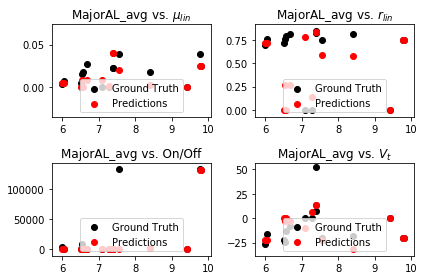

In [27]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['MajorAL_avg'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MajorAL_avg'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MajorAL_avg vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['MajorAL_avg'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MajorAL_avg'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MajorAL_avg vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['MajorAL_avg'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MajorAL_avg'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MajorAL_avg vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['MajorAL_avg'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MajorAL_avg'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MajorAL_avg vs. $V_{t}$')

plt.tight_layout()
plt.show()

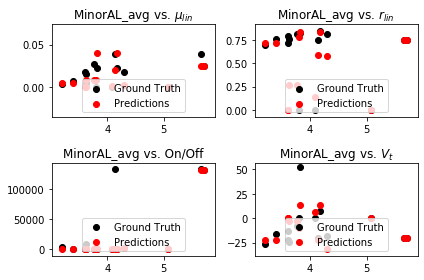

In [28]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['MinorAL_avg'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MinorAL_avg'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MinorAL_avg vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['MinorAL_avg'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MinorAL_avg'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MinorAL_avg vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['MinorAL_avg'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MinorAL_avg'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MinorAL_avg vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['MinorAL_avg'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['MinorAL_avg'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('MinorAL_avg vs. $V_{t}$')

plt.tight_layout()
plt.show()

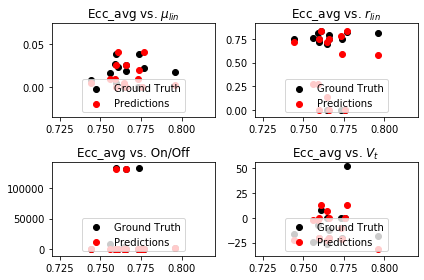

In [29]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['Ecc_avg'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Ecc_avg'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Ecc_avg vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['Ecc_avg'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Ecc_avg'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Ecc_avg vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['Ecc_avg'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Ecc_avg'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Ecc_avg vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['Ecc_avg'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Ecc_avg'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Ecc_avg vs. $V_{t}$')

plt.tight_layout()
plt.show()

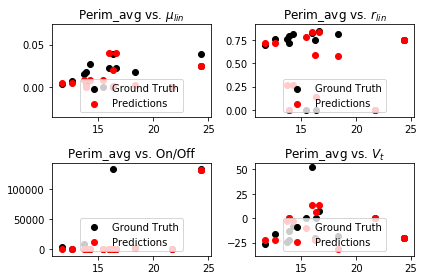

In [30]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['Perim_avg'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Perim_avg'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Perim_avg vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['Perim_avg'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Perim_avg'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Perim_avg vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['Perim_avg'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Perim_avg'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Perim_avg vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['Perim_avg'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Perim_avg'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Perim_avg vs. $V_{t}$')

plt.tight_layout()
plt.show()

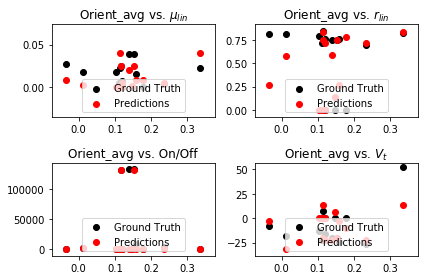

In [31]:
fig1 = plt.Figure(figsize=(25,25))
plt.subplot(221)
plt.scatter(x_test['Orient_avg'], y_test['mu_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Orient_avg'], y_test_pred[:,0], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Orient_avg vs. $\mu_{lin}$')

plt.subplot(222)
plt.scatter(x_test['Orient_avg'], y_test['r_lin_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Orient_avg'], y_test_pred[:,1], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Orient_avg vs. $r_{lin}$')

plt.subplot(223)
plt.scatter(x_test['Orient_avg'], y_test['on_off_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Orient_avg'], y_test_pred[:,2], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Orient_avg vs. On/Off')

plt.subplot(224)
plt.scatter(x_test['Orient_avg'], y_test['Vt_avg'], c = 'k', label = 'Ground Truth')
plt.scatter(x_test['Orient_avg'], y_test_pred[:,3], c = 'r', label = 'Predictions')
plt.legend(loc = 'lower center')
plt.title('Orient_avg vs. $V_{t}$')

plt.tight_layout()
plt.show()

______________________________________________
______________________________________________

# Troubleshooting and developing below here

______________________________________________
______________________________________________

In [30]:
for fl in files:
    print (fl)
    if fl.find('Sub') != -1:
        sub_indeces = fl.index('Sub')
        sub_index = sub_indeces+3
        sub = fl[sub_index]
        print (sub)
        
        if fl.find('postexam') != -1:
            dev = 3
            print (dev)

        else:
            dev_indeces = fl.index('Dev')
            dev_index = dev_indeces+3
            dev = fl[dev_index]
            print (dev)
    
    elif fl.find('Sub') == -1:
        sub_indeces = fl.index('S')
        sub_index = sub_indeces+1
        sub = fl[sub_index]
        print (sub)

        dev_indeces = fl.index('D')
        dev_index = dev_indeces+1
        dev = fl[dev_index]
        print (dev)
        
    else:
        print ('woops')

100C_15min_Sub4_Dev2_domain_metrics.csv
4
2
100C_15min_Sub4_Dev4_domain_metrics.csv
4
4
100C_15min_Sub4_Dev7_domain_metrics.csv
4
7
100C_30min_Sub7_Dev2_domain_metrics.csv
7
2
100C_30min_Sub7_Dev4_domain_metrics.csv
7
4
100C_30min_Sub7_Dev7_domain_metrics.csv
7
7
100C_5min_Sub1_Dev3_domain_metrics.csv
1
3
100C_5min_Sub1_Dev4_90D_domain_metrics.csv
1
4
100C_5min_Sub1_Dev4_domain_metrics.csv
1
4
125C_15min_Sub4_Dev1_domain_metrics.csv
4
1
125C_15min_Sub4_Dev2_domain_metrics.csv
4
2
125C_15min_Sub4_Dev6_domain_metrics.csv
4
6
125C_15min_Sub4_Dev7_domain_metrics.csv
4
7
125C_15min_Sub4_postexam_domain_metrics.csv
4
3
125C_30min_Sub8_Dev3_domain_metrics.csv
8
3
125C_30min_Sub8_postexam_domain_metrics.csv
8
3
125C_5min_Sub1_Dev2_domain_metrics.csv
1
2
125C_5min_Sub1_Dev3_domain_metrics.csv
1
3
125C_5min_Sub1_Dev6_domain_metrics.csv
1
6
125C_5min_Sub1_postexam_domain_metrics.csv
1
3
150C_15min_Sub4_Dev1_domain_metrics.csv
4
1
150C_15min_Sub4_Dev7_domain_metrics.csv
4
7
150C_30min_Sub7_Dev3_do

In [43]:
100 == 100.0

True

In [14]:
time = 10
temp = 100
sub = 3
dev = 1


test = device_df[device_df['Time'] == time]
print (test.shape)

test1 = test[test['Temperature'] == temp]
print (test1.shape)

test2 = test1[test1['Substrate'] == sub]
print (test2.shape)

test3 = test2[test2['Device'] == dev]
print (test3.shape)
test3

(18, 14)
(5, 14)
(3, 14)
(1, 14)


,Unnamed: 0,Sample,Temperature,Time,Substrate,Device,mu_lin_avg,mu_lin_SD,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
22,22,100C-10min_3_IdVg_1_Vd-20,100,10,3,1,0.027205,0.000495,0.751935,0.002915,83456.5773,1672.053023,-18.385927,0.266716


In [17]:
test1

,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate
544,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,1,0,0.677627,0.677331,2.144910,46.642351,7
545,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,2,0,0.628255,0.654254,1.915640,50.127434,7
546,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,3,0,0.667399,0.659943,2.022991,49.990281,7
547,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,4,0,0.725201,0.655834,2.428190,45.538834,7
548,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,5,0,0.323514,0.706579,2.021489,22.649638,7
549,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,6,0,0.620043,0.665916,1.867738,49.852415,7
550,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,7,0,0.670255,0.659979,2.084238,48.726225,7
551,2019_4_16_P3HTPCBM_NA_1000_SUB7,0.0,8,0,0.721146,0.649909,2.436711,45.537223,7
552,2019_4_16_P3HTPCBM_NA_3000_SUB1,0.0,1,0,0.637683,0.662407,2.204954,43.659713,1
553,2019_4_16_P3HTPCBM_NA_3000_SUB1,0.0,2,0,0.706948,0.662689,2.368623,45.038290,1


In [24]:
time = 0
temp = 0
sub = 4
dev = 2


test = total_df[total_df['Anneal_time'] == time]
print (test.shape)

test1 = test[test['Anneal_temp'] == temp]
print (test1.shape)

test2 = test1[test1['Substrate'] == sub]
print (test2.shape)

test3 = test2[test2['Device'] == dev]
print (test3.shape)

test

(0, 19)
(0, 19)
(0, 19)
(0, 19)


,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,mu_lin_avg,r_lin_avg,on_off_avg,Vt_avg
